## Loading and cleaning data

In [1]:
import pandas as pd
import random

In [2]:
# Dataset source: https://huggingface.co/datasets/ronaldahmed/scitechnews
df_train = pd.read_json('data/train.json', lines=True)
df_train.head()

,id,pr-title,pr-article,pr-summary,sc-title,sc-abstract,sc-section_names,sc-sections,sc-article,sc-authors
0,0,New York City's Vaccine Passport Plan Renews O...,When New York City announced on Tuesday that i...,New York's City's mandate that people must sho...,,,[],[],,[]
1,1,Facebook Disables Accounts Tied to NYU Researc...,Facebook Inc. has disabled the personal accoun...,Facebook has disabled the personal accounts of...,,,[],[],,[]
2,2,Teenage Girls in Northern Nigeria 'Open Their ...,"KANO, Nigeria, Aug 2 (Reuters) - Teenage girls...",The Kabara non-governmental organization (NGO)...,,,[],[],,[]
3,3,3D 'Heat Map' Animation Shows How Seizures Spr...,"For 29 years, from the time she was 12, Rashet...","University of California, San Francisco (UCSF)...",,,[],[],,[]
4,4,Endlessly Changing Playground Teaches AIs to M...,What did they learn? Some of DeepMind's XLand ...,Alphabet's DeepMind Technologies has developed...,,,[],[],,[]


Now keep only pertinent columns:

In [3]:
df_train = df_train[['pr-title', 'pr-article']]

df_train['pr-article'] = df_train['pr-article'].astype('string')
df_train['pr-title'] = df_train['pr-title'].astype('string')

df_train.head()

,pr-title,pr-article
0,New York City's Vaccine Passport Plan Renews O...,When New York City announced on Tuesday that i...
1,Facebook Disables Accounts Tied to NYU Researc...,Facebook Inc. has disabled the personal accoun...
2,Teenage Girls in Northern Nigeria 'Open Their ...,"KANO, Nigeria, Aug 2 (Reuters) - Teenage girls..."
3,3D 'Heat Map' Animation Shows How Seizures Spr...,"For 29 years, from the time she was 12, Rashet..."
4,Endlessly Changing Playground Teaches AIs to M...,What did they learn? Some of DeepMind's XLand ...


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26638 entries, 0 to 26637
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pr-title    26638 non-null  string
 1   pr-article  26638 non-null  string
dtypes: string(2)
memory usage: 416.3 KB


The dataset has empty article rows, which are not important for our task.

Remove empty articles (articles where title is all the info., so they don't need a new title)

In [5]:
df_train = df_train[df_train['pr-article'] != '']
print('Train dataframe size without blanks: ', len(df_train))

Train dataframe size without blanks:  12735


Print a random article and title:

In [6]:
random_article_idx = random.randint(0, len(df_train))
row = df_train.iloc[random_article_idx]
print('News example: ', random_article_idx)
print('Title:    \n', row['pr-title'])
print('Article:  \n', row['pr-article'])

News example:  8540
Title:    
 Empowering a New Generation of Tech-Savvy Women by Teaching Them to Code
Article:  
 Paula Bernstein has written about television, film, advertising, and technology for Fast Company, Variety, The Hollywood Reporter, Adweek, Babble, and various other digital and print publications. She is also the co-author of "Identical Strangers: A Memoir of Twins Separated and Reunited."
More


See article lengths distribution (in chars and words):

Text(0, 0.5, 'Counts')

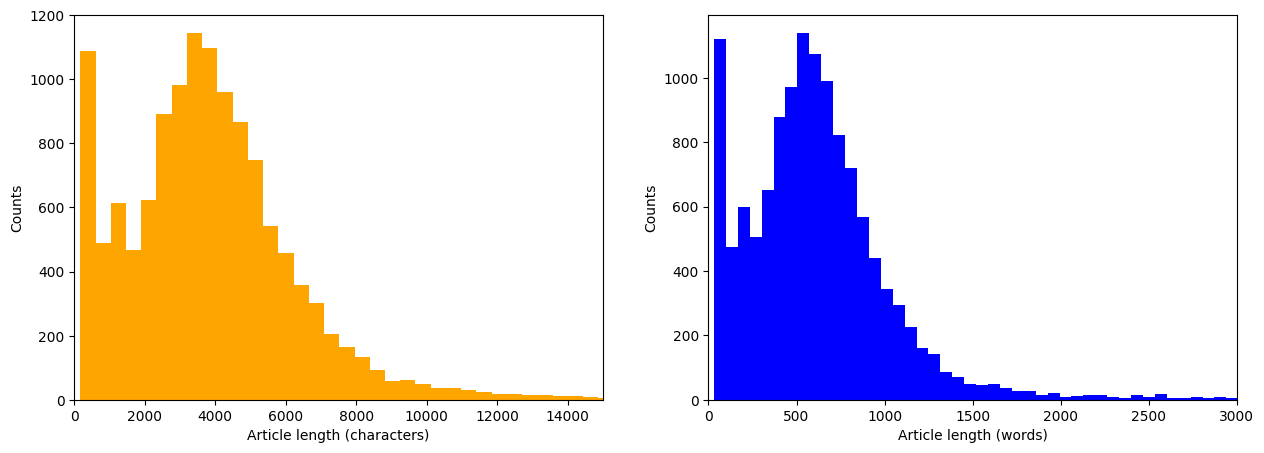

In [7]:
import matplotlib.pyplot as plt

article_lengths = df_train['pr-article'].str.len()
article_word_counts = df_train['pr-article'].str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(article_lengths, bins=150, color='orange')
ax[0].set_xlim(0, 15000)
ax[0].set_xlabel('Article length (characters)')
ax[0].set_ylabel('Counts')

ax[1].hist(article_word_counts, bins=150, color='blue')
ax[1].set_xlim(0, 3000)
ax[1].set_xlabel('Article length (words)')
ax[1].set_ylabel('Counts')

Repeat cleaning process for valid and test datasets

In [8]:
df_valid = pd.read_json('data/valid.json', lines=True)
df_valid = df_valid[['pr-title', 'pr-article']]
df_valid['pr-article'] = df_valid['pr-article'].astype('string')
df_valid['pr-title'] = df_valid['pr-title'].astype('string')

df_test = pd.read_json('data/test.json', lines=True)
df_test = df_test[['pr-title', 'pr-article']]
df_test['pr-article'] = df_test['pr-article'].astype('string')
df_test['pr-title'] = df_test['pr-title'].astype('string')

print('Valid dataframe size: ', len(df_valid))
print('Test dataframe size:  ', len(df_test))

Valid dataframe size:  1431
Test dataframe size:   1000


In [9]:
df_valid = df_valid[df_valid['pr-article'] != '']
df_valid = df_valid[df_valid['pr-title'] != '']
print('Valid dataframe size without blanks: ', len(df_valid))
print('Test dataframe size without blanks:  ', len(df_test))

Valid dataframe size without blanks:  1405
Test dataframe size without blanks:   1000


## Fine-tuning T5

### Defininf model and loading tokenizer

In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import torch

model_name = "t5-small"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
tokenizer = T5Tokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### Preprocess data for model function

In [12]:
max_length = 256

def preprocess_data(batch):
    """preprocess a batch of data for T5 title generation task"""
    input_texts = ['summarize: ' + article for article in batch['pr-article']]
    target_texts = batch['pr-title']

    # tokenize input and target texts with padding to ensure consistent shape
    tokenized_inputs = tokenizer(input_texts,
                                  max_length=max_length,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors="pt")

    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(target_texts,
                                   max_length=max_length,
                                   padding='max_length',
                                   truncation=True,
                                   return_tensors="pt")

    # convert to dictionary compatible for Hugging Face Datasets
    return {
        "input_ids": tokenized_inputs["input_ids"],
        "attention_mask": tokenized_inputs["attention_mask"],
        "labels": tokenized_targets["input_ids"]
    }

Now apply preprocess function to all datasets:

In [13]:
from datasets import Dataset

batch_size = 8

tokenized_train_ds = Dataset.from_pandas(df_train).map(preprocess_data, batched=True, batch_size=batch_size)
tokenized_valid_ds = Dataset.from_pandas(df_valid).map(preprocess_data, batched=True, batch_size=batch_size)
tokenized_test_ds = Dataset.from_pandas(df_test).map(preprocess_data, batched=True, batch_size=batch_size)

Map:   0%|          | 0/12735 [00:00<?, ? examples/s]

/home/neville/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1405 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
# keep only the required fields for the Seq2Seq trainer (input_ids, attention_mask, labels)
tokenized_train_ds = tokenized_train_ds.remove_columns(['pr-title', 'pr-article'])
tokenized_valid_ds = tokenized_valid_ds.remove_columns(['pr-title', 'pr-article'])
tokenized_test_ds = tokenized_test_ds.remove_columns(['pr-title', 'pr-article'])

In [15]:
tokenized_train_ds

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 12735
})

### Prepare trainer

In [16]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir='./model/T5-title-generation',
    eval_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=700,
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True, # true for generative metrics like rouge
    fp16=True, # faster training
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
)

Data collator for the trainer:

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, label_pad_token_id=-100)

### Metric selection

In [18]:
from evaluate import load

metric = load("rouge")
metric

EvaluationModule(name: "rouge", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id=None)}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLsum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/

In [19]:
import numpy as np
import nltk
nltk.download('punkt_tab')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip()))
                      for label in decoded_labels]

    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value * 100 for key, value in result.items()}  # returns dict of scalars

    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    # Round results to 4 decimal places
    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/neville/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [20]:
# Example predictions and labels
pred = tokenizer(["This is a test generation"], padding="max_length", truncation=True, return_tensors="pt")["input_ids"]
label = tokenizer(["This is the reference summary"], padding="max_length", truncation=True, return_tensors="pt")["input_ids"]

# Pass to compute_metrics
metrics = compute_metrics((pred.numpy(), label.numpy()))
print(metrics)

{'rouge1': 40.0, 'rouge2': 25.0, 'rougeL': 40.0, 'rougeLsum': 40.0, 'gen_len': 7.0}


### Start trainer

In [21]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [22]:
print(model.config)

T5Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stoppin

In [23]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [24]:
model.num_parameters()

60506624

The model has 12x Encoders and 12x Decoders

In [25]:
model.n_positions = 256

In [26]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_421940/4080436188.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [27]:
%time
trainer.train()

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.15 μs


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,3.986700,0.306963,0.000000,0.000000,0.000000,0.000000,0.000000


KeyboardInterrupt: 

In [30]:
print(tokenized_train_ds[1300])
print(tokenized_valid_ds[13])

{'__index_level_0__': 1852, 'input_ids': [21603, 10, 96, 11836, 271, 16, 9952, 6, 62, 317, 132, 31, 7, 3, 9, 72, 4290, 1295, 976, 8, 372, 4297, 243, 5, 180, 6761, 7, 31, 7, 671, 748, 54, 7037, 3, 9, 1959, 31, 7, 1283, 18, 6636, 1634, 6, 84, 96, 159, 3, 5828, 1934, 12, 2323, 250, 1634, 11, 6460, 13, 13608, 33, 16569, 11, 27875, 11445, 535, 37, 166, 34, 49, 1628, 13, 180, 6761, 7, 31, 7, 889, 130, 1597, 386, 203, 977, 57, 71, 354, 935, 23, 6, 113, 3, 4774, 95, 3, 9, 2386, 1624, 7, 7815, 1819, 16, 10271, 11, 2461, 15, 26, 13, 2852, 46, 445, 5, 371, 5, 434, 5, 879, 2743, 5, 216, 6812, 12, 19669, 6, 112, 1900, 1565, 6, 81, 149, 199, 3370, 2323, 582, 72, 2918, 5, 37, 146, 32, 6, 113, 92, 1130, 8498, 11, 10749, 6, 857, 3370, 19, 59, 38, 2496, 38, 119, 2100, 16, 338, 10069, 748, 5, 96, 1326, 141, 2087, 874, 912, 13, 213, 3370, 19, 3, 40, 15242, 1187, 6, 213, 34, 4227, 72, 625, 496, 145, 126, 496, 976, 19669, 243, 5, 71, 354, 935, 23, 1279, 38, 46, 9342, 44, 8, 445, 5, 371, 5, 434, 5, 16, 8, 12